In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import skimage.measure as sm 

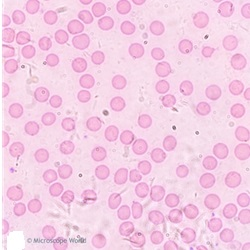

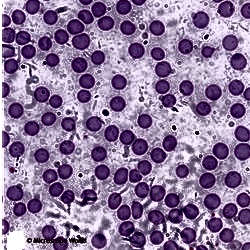

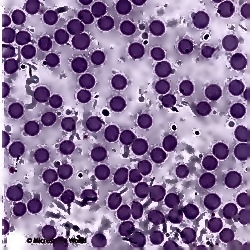

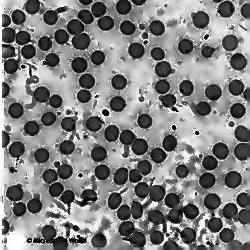

In [0]:
# Load image
image_bgr = cv2.imread('blob.jpg')
cv2_imshow(image_bgr)
image_yuv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2YUV)
image_yuv[:, :, 0] = cv2.equalizeHist(image_yuv[:, :, 0])
image_rgb = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)
cv2_imshow(image_rgb)
shifted = cv2.pyrMeanShiftFiltering(image_rgb, 0, 80)
cv2_imshow(shifted)
im2 = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
cv2_imshow(im2)

In [0]:
np.mean(im2)

128.750944

# Image Segmentation

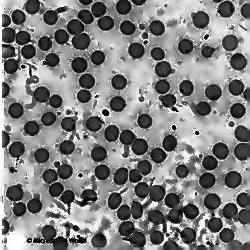

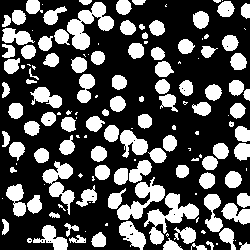

In [0]:
ret,thresh1 = cv2.threshold(im2,80,255,cv2.THRESH_BINARY_INV)
cv2_imshow(im2)
cv2_imshow(thresh1)

## Structuring Elements

In [0]:
kernel = np.ones((3,3),np.uint8)
kernel1 = np.ones((4,4),np.uint8)
kernel2 = np.ones((2,2),np.uint8)
ellipse_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,1))
ellipse_kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))
ellipse_kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
ellipse_kernel3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
ellipse_kernel4 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
diag = np.zeros([4,4],np.uint8)
diag[2,1] = 1
diag[1,2] = 1
diag2 = np.zeros([4,4],np.uint8)
diag2[1,1] = 1
diag2[2,2] = 1
cross = np.array([[0, 0, 0, 0, 0],
               [0, 1, 0, 1, 0],
               [0, 0, 1, 0, 0],
               [0, 1, 0, 1, 0],
               [0, 0, 0, 0, 0]], np.uint8)

In [0]:
im_erode = cv2.erode(thresh1, ellipse_kernel3, iterations = 1)
im_erode1 = cv2.erode(im_erode, diag2, iterations = 1)
im_erode2 = cv2.erode(im_erode1, cross, iterations = 1)
im_dilate = cv2.dilate(im_erode2, cross, iterations = 1)

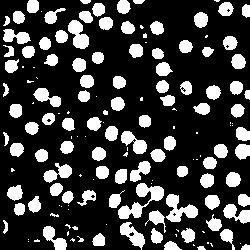

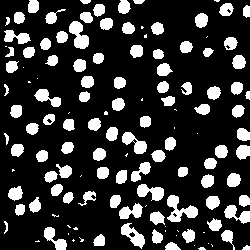

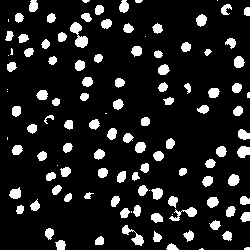

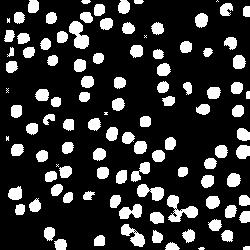

In [0]:
cv2_imshow(im_erode)
cv2_imshow(im_erode1)
cv2_imshow(im_erode2)
cv2_imshow(im_dilate)

# Morphological Operations

In [0]:
# noise removal
kernels = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(im_dilate,cv2.MORPH_OPEN,kernels, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernels,iterations=2)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,3)
ret, sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0)
# Finding unknown region

sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

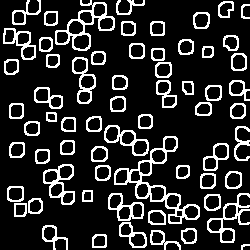

In [0]:
cv2_imshow(unknown)

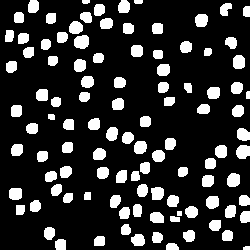

In [0]:
cv2_imshow(sure_fg)

In [0]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

In [0]:
markers = cv2.watershed(shifted,markers)
shifted[markers == -1] = [255,0,0]
markers

array([[ -1,  -1,  -1, ...,  -1,  -1,  -1],
       [ -1,   1,   1, ...,   1,   1,  -1],
       [ -1,   1,   1, ...,   1,   1,  -1],
       ...,
       [ -1,   1,   1, ..., 106, 106,  -1],
       [ -1,   1,   1, ..., 106, 106,  -1],
       [ -1,  -1,  -1, ...,  -1,  -1,  -1]], dtype=int32)

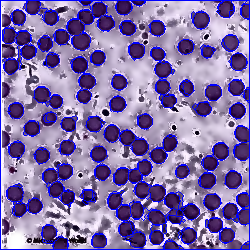

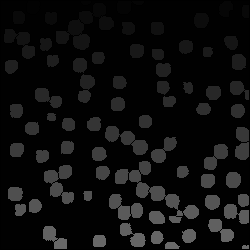

In [0]:
cv2_imshow(shifted)
cv2_imshow(markers)

In [0]:
node = markers
node

array([[ -1,  -1,  -1, ...,  -1,  -1,  -1],
       [ -1,   1,   1, ...,   1,   1,  -1],
       [ -1,   1,   1, ...,   1,   1,  -1],
       ...,
       [ -1,   1,   1, ..., 106, 106,  -1],
       [ -1,   1,   1, ..., 106, 106,  -1],
       [ -1,  -1,  -1, ...,  -1,  -1,  -1]], dtype=int32)

In [0]:
node = markers
node[markers ==-1] = 0
node[markers == 1] = 0
node[markers != 0] = 255
segments = im_dilate.astype('uint8')
segments[im_dilate != node] = 0

In [0]:
node

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 255, 255,   0],
       [  0,   0,   0, ..., 255, 255,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)

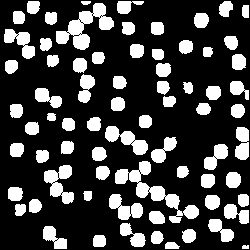

(250, 250)

In [0]:
cv2_imshow(node)
np.shape(node)

In [0]:
segments

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 255, 255,   0],
       [  0,   0,   0, ..., 255, 255,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

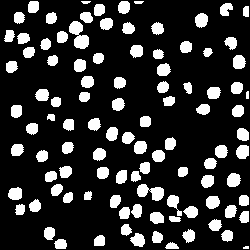

In [0]:
cv2_imshow(segments)

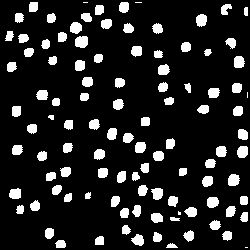

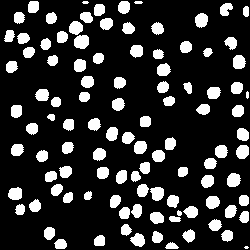

In [0]:
erode1 = cv2.erode(segments,ellipse_kernel2)
cv2_imshow(erode1)
dilate1 = cv2.dilate(erode1,ellipse_kernel2)
cv2_imshow(dilate1)

In [0]:
# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()

# Filter by Color
params.filterByColor = True
params.blobColor = 255
 
# Filter by Area.
params.filterByArea = True
params.minArea = 18
params.maxArea = 250
 
# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0
 
# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0
 
# Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0

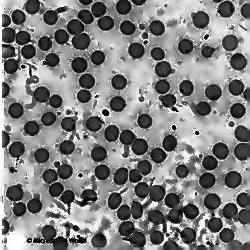

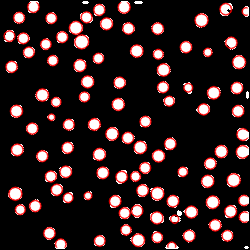

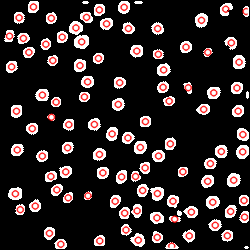

In [0]:
detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(dilate1)
im_with_keypoints = cv2.drawKeypoints(dilate1, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
im_with_keypoints2 = cv2.drawKeypoints(dilate1, keypoints, np.array([]), (0,0,255))
cv2_imshow(im2)
cv2_imshow(im_with_keypoints)
cv2_imshow(im_with_keypoints2)

In [0]:
label

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 105, 105,   0],
       [  0,   0,   0, ..., 105,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

In [0]:
label, N = sm.label(dilate1, background=0, return_num=True)
reg = sm.regionprops(label,dilate1)

area = []
eccen = []
mal = []
per= []
for i in range(N):
  if reg[i].area > 18:
    area.append(reg[i].area)
    eccen.append(reg[i].eccentricity)
    mal.append(reg[i].major_axis_length)
    per.append(reg[i].perimeter)
  else:
    continue
    
print('AREA = ',np.mean(area),'+/-',np.std(area))
print('Eccentricity = ',np.mean(eccen),'+/-',np.std(eccen))
print('Major Axis Length = ',np.mean(mal),'+/-',np.std(mal))
print('Perimeter = ',np.mean(per),'+/-',np.std(per))

In [0]:
len(reg)

105

In [0]:
reg[0].area

120

In [0]:
len(area)

103

In [0]:
import pandas as pd

In [0]:
dataset = pd.DataFrame({'Area': area, 'Eccentricity': eccen, 'M-A-L': mal, 'Perimeter':per})

In [0]:
dataset.head()

,Area,Eccentricity,M-A-L,Perimeter
0,120,0.530392,13.467008,37.899495
1,131,0.426226,13.573269,39.556349
2,23,0.937715,8.983076,17.656854
3,121,0.718479,15.507373,45.213203
4,116,0.511194,13.148713,37.313708


AREA =  113.16504854368932 +/- 27.915300842264774
Eccentricity =  0.5063820230193725 +/- 0.1350160351230456
Major Axis Length =  12.975629576757147 +/- 1.565056814085581
Perimeter =  37.32283722660784 +/- 5.5480299736440415
